In [12]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 500

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')


Input data shape: (60000, 28, 28)
Number of labels: 60000


In [4]:
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


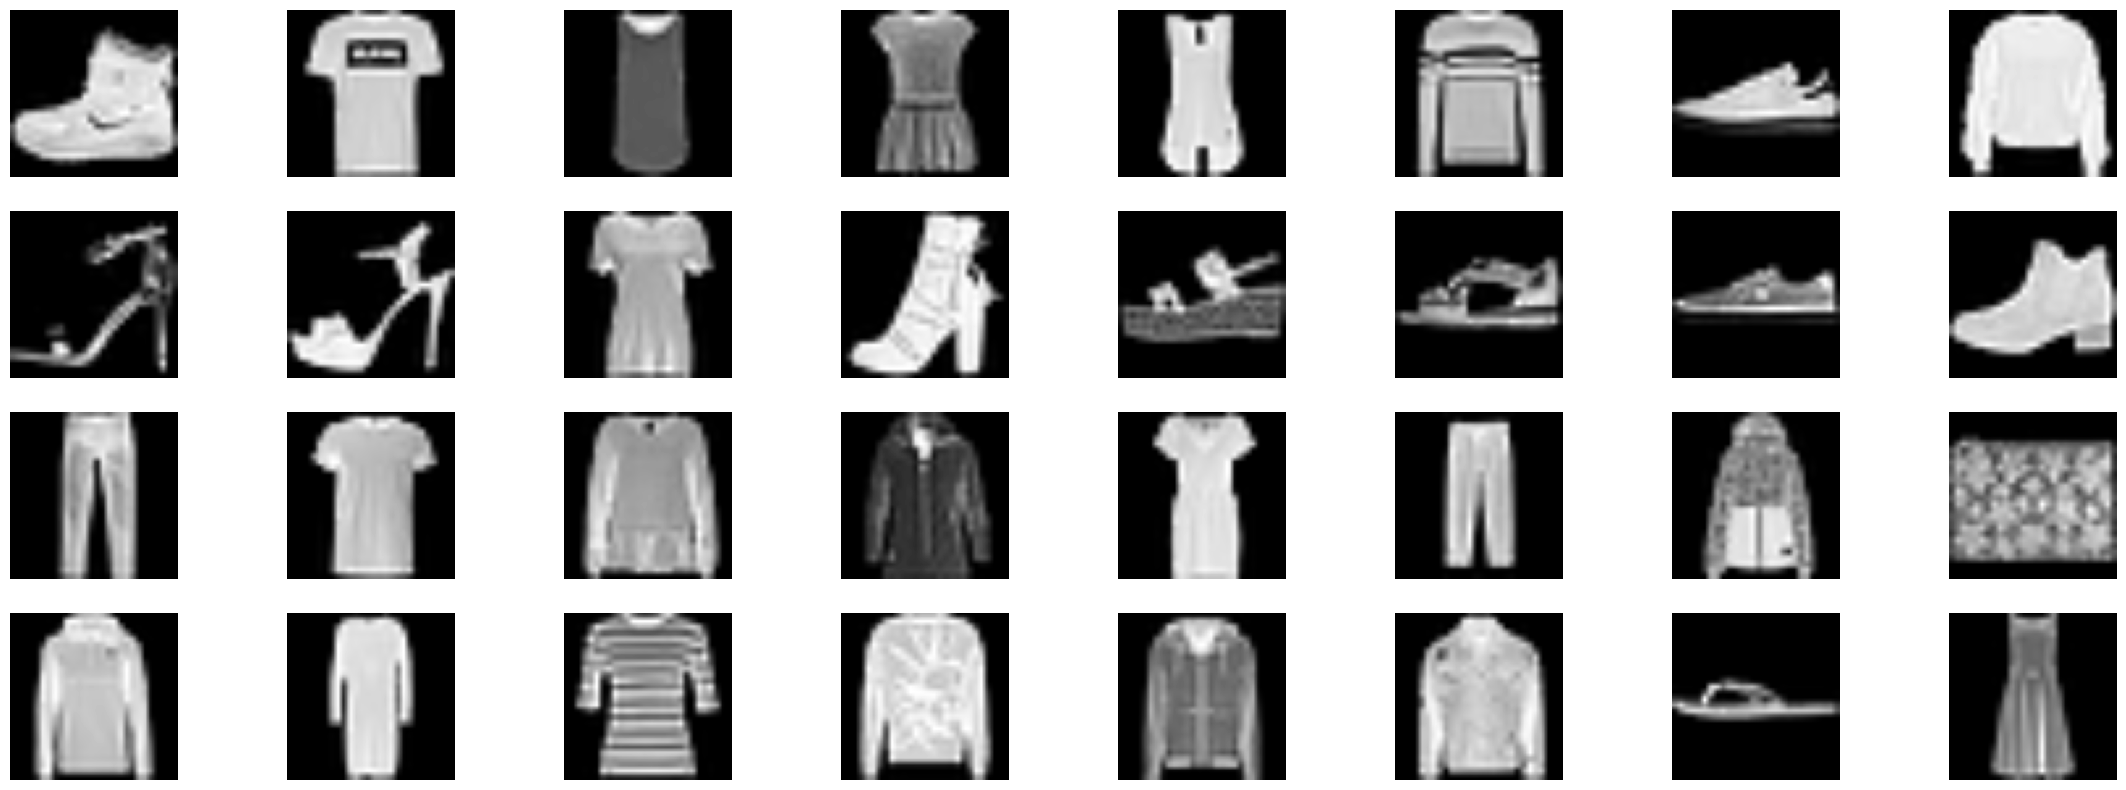

In [5]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)

    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')

    counter += 1
    if counter == cnt_imgs:
        break


In [6]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [7]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)


In [8]:
hidden_dim = 20


In [9]:
generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))


In [10]:
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             263424    
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                         

In [13]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=(28,28,1,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))


In [14]:
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [15]:
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


In [16]:
@tf.function
def train_step(images) -> (float, float):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss


In [17]:
def train(dataset,  epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in  generator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)

    for epoch in range(1, EPOCHS + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end = ' ')

        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
    return history


In [18]:
EPOCHS = 100
gen_history = train(train_dataset, EPOCHS)


1/100: ==========> : loss = tf.Tensor(1.0806332, shape=(), dtype=float32)
The time of the epoch 1 is: 28.797443151474 second
2/100: ==========> : loss = tf.Tensor(1.1295034, shape=(), dtype=float32)
The time of the epoch 2 is: 10.110074996948242 second
3/100: ==========> : loss = tf.Tensor(0.824168, shape=(), dtype=float32)
The time of the epoch 3 is: 20.46392297744751 second
4/100: ==========> : loss = tf.Tensor(0.8317377, shape=(), dtype=float32)
The time of the epoch 4 is: 10.555803298950195 second
5/100: ==========> : loss = tf.Tensor(0.8241971, shape=(), dtype=float32)
The time of the epoch 5 is: 10.839725017547607 second
6/100: ==========> : loss = tf.Tensor(0.846942, shape=(), dtype=float32)
The time of the epoch 6 is: 11.068543672561646 second
7/100: ==========> : loss = tf.Tensor(0.89822584, shape=(), dtype=float32)
The time of the epoch 7 is: 10.972833156585693 second
8/100: ==========> : loss = tf.Tensor(0.9245232, shape=(), dtype=float32)
The time of the epoch 8 is: 10.6639

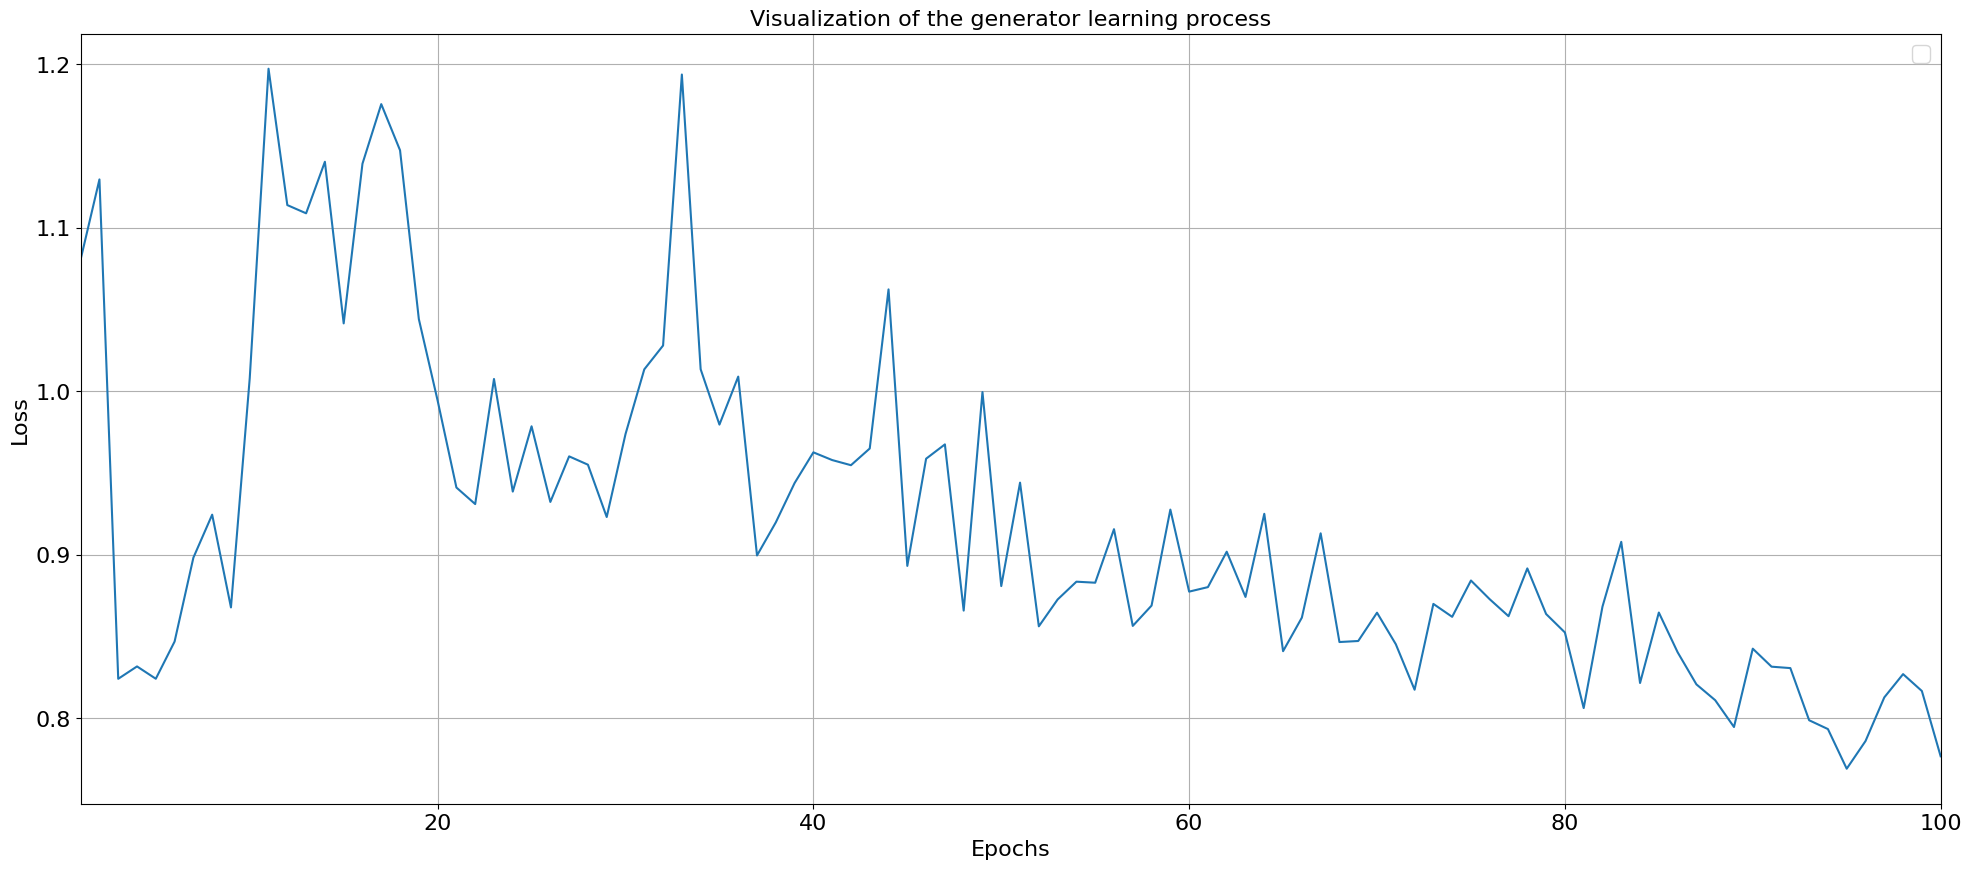

In [19]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()


1/1 [==============================] - 0s 19ms/step


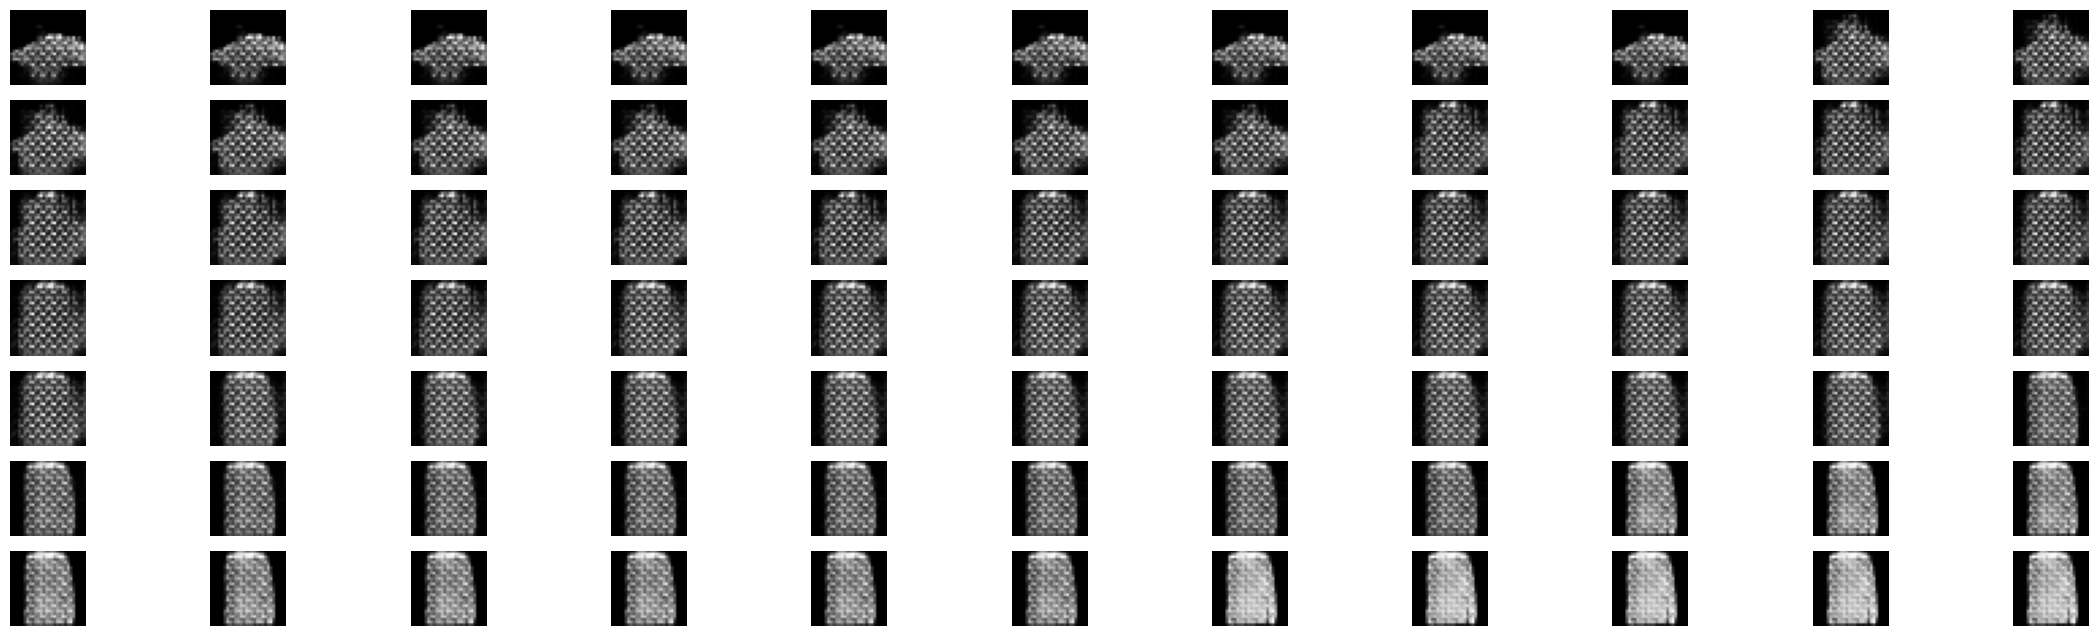

In [20]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1

        ip_data = np.array([0.5*i/n for _ in range(20)])
        ip_data = np.expand_dims(ip_data,axis=0)
        img = generator.predict(ip_data)
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()


In [22]:
EPOCHS = 50 # 150
gen_history = train(train_dataset, EPOCHS)


1/50: ==========> : loss = tf.Tensor(0.78874606, shape=(), dtype=float32)
The time of the epoch 1 is: 10.50860333442688 second
2/50: ==========> : loss = tf.Tensor(0.82665235, shape=(), dtype=float32)
The time of the epoch 2 is: 10.780678272247314 second
3/50: ==========> : loss = tf.Tensor(0.84352106, shape=(), dtype=float32)
The time of the epoch 3 is: 11.069030046463013 second
4/50: ==========> : loss = tf.Tensor(0.7858861, shape=(), dtype=float32)
The time of the epoch 4 is: 10.955014705657959 second
5/50: ==========> : loss = tf.Tensor(0.8845545, shape=(), dtype=float32)
The time of the epoch 5 is: 10.6354398727417 second
6/50: ==========> : loss = tf.Tensor(0.82618743, shape=(), dtype=float32)
The time of the epoch 6 is: 10.46669602394104 second
7/50: ==========> : loss = tf.Tensor(0.78358626, shape=(), dtype=float32)
The time of the epoch 7 is: 10.397132873535156 second
8/50: ==========> : loss = tf.Tensor(0.81737596, shape=(), dtype=float32)
The time of the epoch 8 is: 10.39424

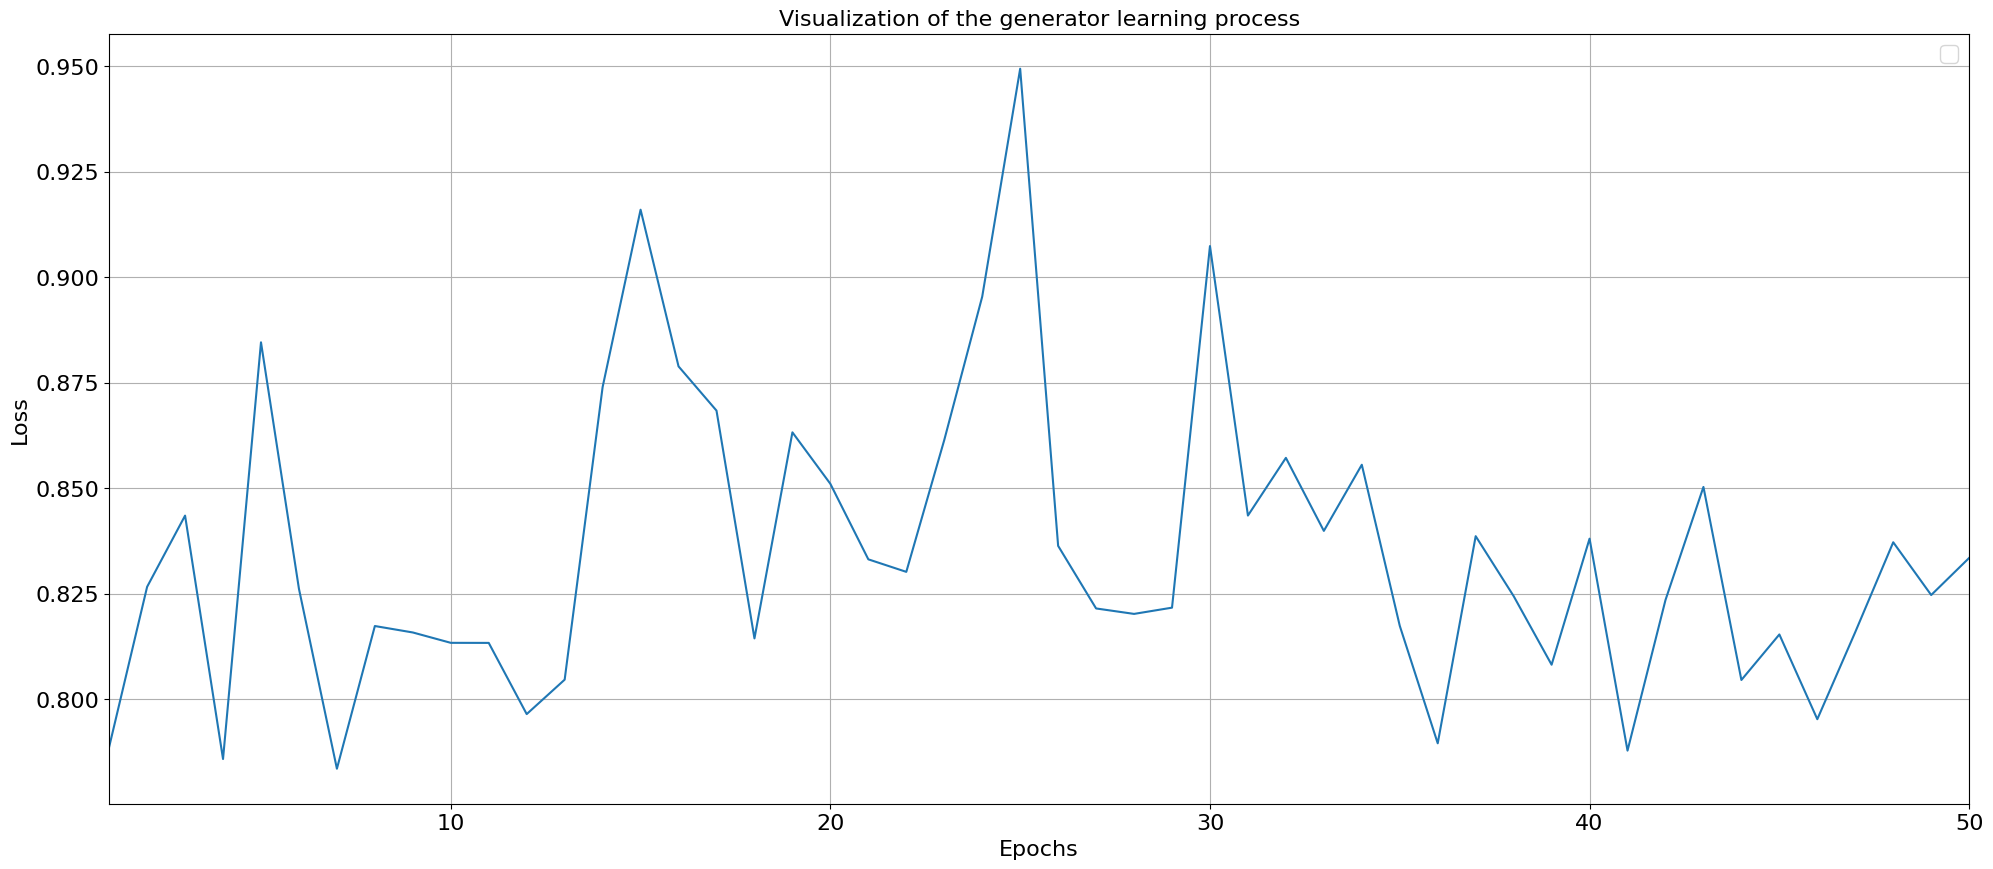

In [23]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

1/1 [==============================] - 0s 19ms/step


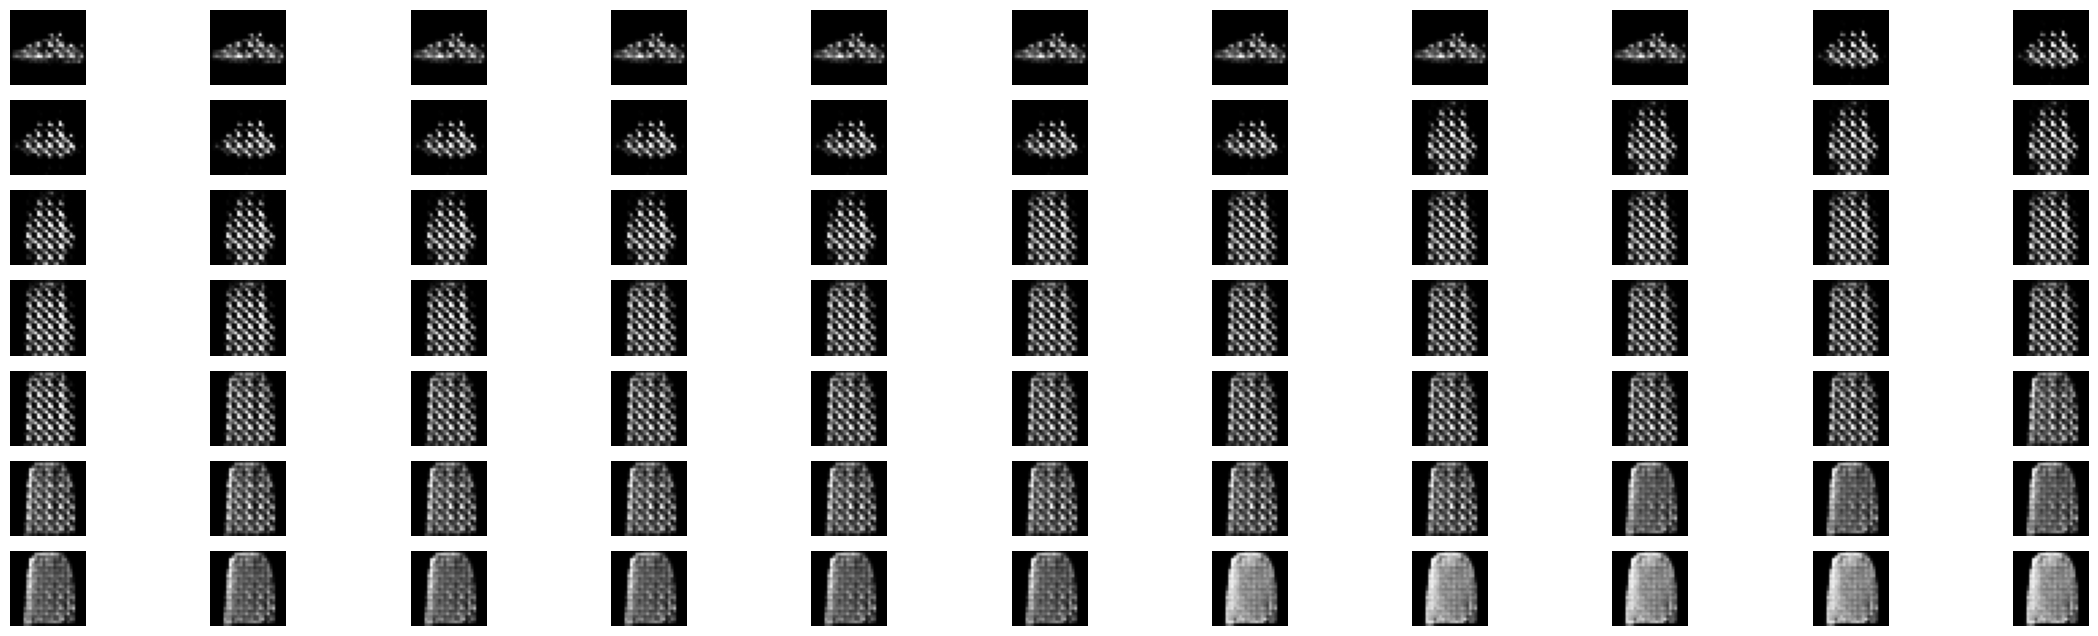

In [24]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1

        ip_data = np.array([0.5*i/n for _ in range(20)])
        ip_data = np.expand_dims(ip_data,axis=0)
        img = generator.predict(ip_data)
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()

In [25]:
EPOCHS = 50 # 200
gen_history = train(train_dataset, EPOCHS)

1/50: ==========> : loss = tf.Tensor(0.8507108, shape=(), dtype=float32)
The time of the epoch 1 is: 10.512123584747314 second
2/50: ==========> : loss = tf.Tensor(0.8469621, shape=(), dtype=float32)
The time of the epoch 2 is: 10.631160020828247 second
3/50: ==========> : loss = tf.Tensor(0.8801371, shape=(), dtype=float32)
The time of the epoch 3 is: 10.825272798538208 second
4/50: ==========> : loss = tf.Tensor(0.8488618, shape=(), dtype=float32)
The time of the epoch 4 is: 10.675325393676758 second
5/50: ==========> : loss = tf.Tensor(0.830075, shape=(), dtype=float32)
The time of the epoch 5 is: 20.466942310333252 second
6/50: ==========> : loss = tf.Tensor(0.9244512, shape=(), dtype=float32)
The time of the epoch 6 is: 10.385880947113037 second
7/50: ==========> : loss = tf.Tensor(0.9519837, shape=(), dtype=float32)
The time of the epoch 7 is: 10.553301572799683 second
8/50: ==========> : loss = tf.Tensor(0.8979639, shape=(), dtype=float32)
The time of the epoch 8 is: 10.87196588

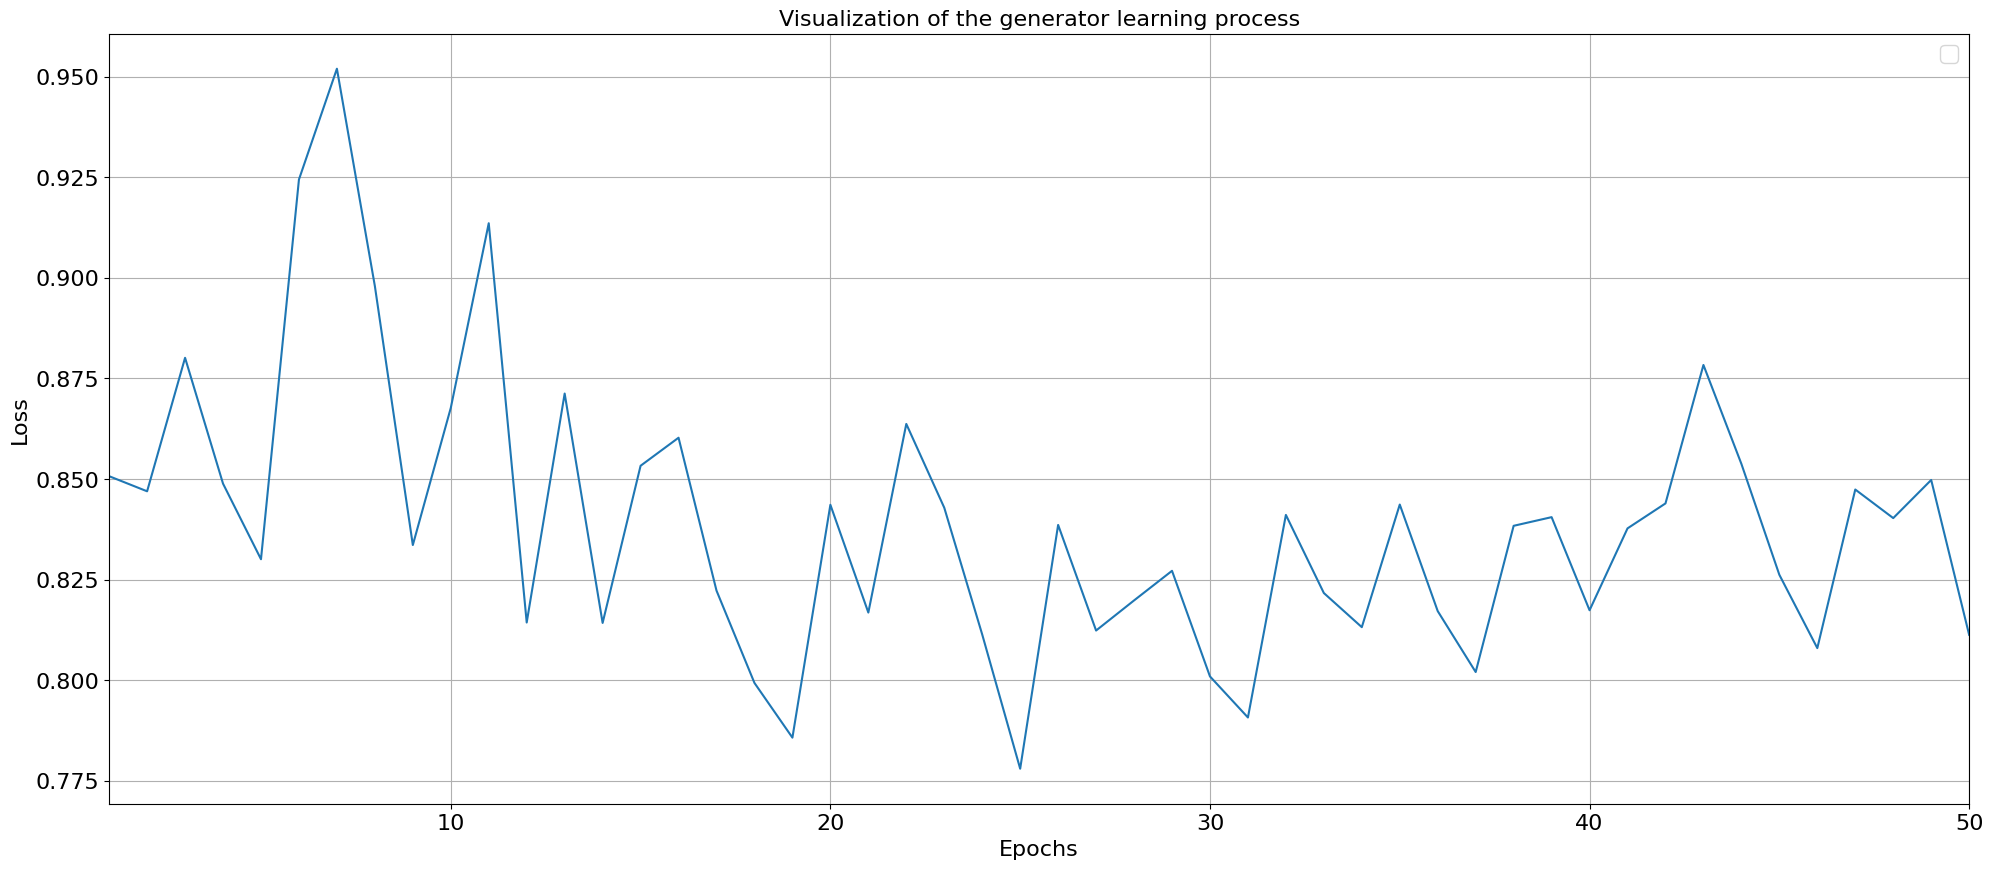

In [26]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

1/1 [==============================] - 0s 19ms/step


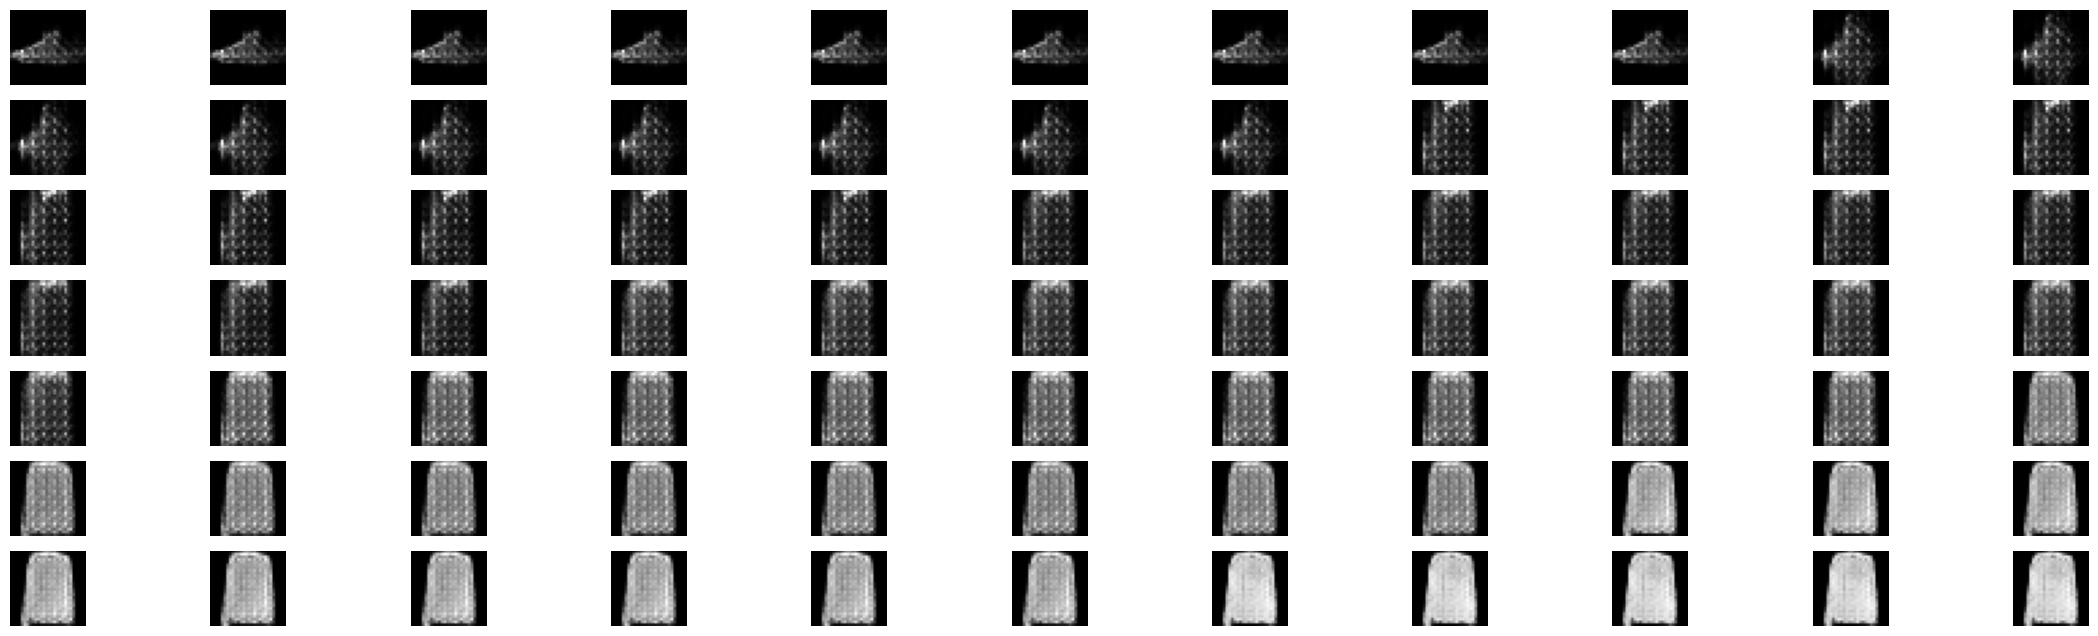

In [27]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1

        ip_data = np.array([0.5*i/n for _ in range(20)])
        ip_data = np.expand_dims(ip_data,axis=0)
        img = generator.predict(ip_data)
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()